In [1]:
# from tqdm import tqdm
from tqdm.notebook import tqdm

import json 
import pandas as pd
import polars as pl
import unicodedata

import polars as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt

In [2]:
class StarRatingDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        # Convert label to a one-hot vector: label in {1,...,5} -> one-hot of length 5
        y_onehot = torch.zeros(5)
        y_onehot[self.y[idx]-1] = 1.0
        return x, y_onehot

In [3]:
# train_dataset = torch.load('../data/2_training_ready/embedding00/train_dataset00.pth')
# test_dataset = torch.load('../data/2_training_ready/embedding00/test_dataset00.pth')
# val_dataset = torch.load('../data/2_training_ready/embedding00/val_dataset00.pth')
test_dataset = torch.load('../data/2_training_ready/embedding00/test_dataset01.pth')
val_dataset = torch.load('../data/2_training_ready/embedding00/val_dataset01.pth')

/tmp/ipykernel_5955/3211474504.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_dataset = torch.load('../data/2_training_ready/embedding00/test_dataset01.pth')
/tmp/

In [4]:
training1 = torch.load("../data/2_training_ready/embedding00/train_dataset01.pth")
training2 = torch.load("../data/2_training_ready/embedding00/train_dataset02.pth")
training3 = torch.load("../data/2_training_ready/embedding00/train_dataset03.pth")
training4 = torch.load("../data/2_training_ready/embedding00/train_dataset04.pth")

# # Combine the embeddings and labels
# combined_embeddings = torch.cat([training1.X, training2.X, training3.X,training4.X], dim=0)
# combined_labels = torch.cat([training1.y, training2.y, training3.y,training4.y], dim=0)
# # 
# # # Create a new EmbeddingDataset with the combined data
# train_dataset = StarRatingDataset(combined_embeddings.numpy(), combined_labels.numpy())

/tmp/ipykernel_5955/3878769508.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training1 = torch.load("../data/2_training_ready/embedding00/train_dataset01.pth")
/tmp/ip

In [7]:
# Concatenate all X values
combined_X = np.concatenate([
    training1.X,
    training2.X,
    training3.X,
    training4.X
], axis=0)

# Concatenate all y values
combined_y = np.concatenate([
    training1.y,
    training2.y,
    training3.y,
    training4.y
], axis=0)

# Create a new dataset with the combined data
train_dataset = StarRatingDataset(combined_X, combined_y)

In [8]:
_X_, _y_ = train_dataset[0]  # Get the first sample
print(f"Shape of X: {_X_.shape}")
print(f"Shape of y: {_y_.shape if isinstance(_y_, torch.Tensor) else type(_y_)}")

Shape of X: torch.Size([1024])
Shape of y: torch.Size([5])


In [9]:
class ReviewRatingPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=5, dropout_rate=0.3):
        """
        Args:
            input_dim (int): Size of the input embeddings.
            hidden_dim (int): Number of units in the hidden layers.
            output_dim (int): Number of output classes (e.g., star ratings 1-5).
            dropout_rate (float): Dropout rate for regularization.
        """
        super(ReviewRatingPredictor, self).__init__()
        
        # Fully connected layers with dropout for regularization
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, output_dim)
        )
        
    def forward(self, x):
        return self.fc(x)
    
model = ReviewRatingPredictor(input_dim = train_dataset[0][0].shape[0])
model = model.to("cuda")

In [ ]:
# # model def 
# class SimpleRegressor(nn.Module):
#     def __init__(self, input_dim, hidden_dim=128):
#         super(SimpleRegressor, self).__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_dim, 5)  # 5 outputs for probabilities
#         
#     def forward(self, x):
#         out = self.fc1(x)
#         out = self.relu(out)
#         out = self.fc2(out)  # logits
#         return out
# 
# input_dim = train_dataset[0][0].shape[0]
# model = SimpleRegressor(input_dim)
# model = model.to("cuda")  # or "cuda" if available

In [24]:
# # loss
# def emd_loss(y_pred, y_true):
#     # y_pred: (batch, 5) logits
#     # y_true: (batch, 5) one-hot vectors
#     p = torch.softmax(y_pred, dim=1)
#     P = torch.cumsum(p, dim=1)
#     Q = torch.cumsum(y_true, dim=1)
#     emd = torch.sum(torch.abs(P - Q), dim=1)  # sum over the five dimensions
#     return torch.mean(emd)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [11]:
eval_every = 100
eval_for = 10

In [12]:
criterion = torch.nn.CrossEntropyLoss()

# train
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 1  

lst_train_loss = []
lst_eval_loss = []
lst_hit_rates = []

for epoch in range(num_epochs):
    model.train()
    
    ix = 0
    # for batch_x, batch_y in train_loader:
    for batch_x, batch_y in tqdm(train_loader, desc="Training", unit="batch"):
        
        train_loss = 0.0
        optimizer.zero_grad()
        
        # TK REMOVE FOR EMD
        batch_y = torch.argmax(batch_y, dim=1) 
        
        batch_x = batch_x.to("cuda")
        batch_y = batch_y.to("cuda")
        
        pred = model(batch_x)
        # loss = emd_loss(pred, batch_y)
        loss = criterion(pred, batch_y)     
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * len(batch_x)
        lst_train_loss.append(train_loss)
        
        ix = ix + 1
        if ix % eval_every == 0:
            
            # Evaluate on test set
            model.eval()
            test_loss = 0.0
            correct = 0
            total = 0
            eval_ix = 0
            with torch.no_grad():
                for batch_x, batch_y in test_loader:
                    if eval_ix >= eval_for:
                        break  # Stop after eval_for steps
                    
                    # TK REMOVE FOR EMD    
                    batch_y = torch.argmax(batch_y, dim=1) 
                    
                    batch_x = batch_x.to("cuda")
                    batch_y = batch_y.to("cuda")
                
                    pred = model(batch_x)
                    # loss = emd_loss(pred, batch_y)
                    loss = criterion(pred, batch_y)                   
                    test_loss += loss.item() * len(batch_x)
            
                    # Compute hit rate
                    # y_pred_classes: argmax of predictions
                    # y_true_classes: argmax of one-hot labels
                    y_pred_classes = torch.argmax(torch.softmax(pred, dim=1), dim=1)
                    # y_true_classes = torch.argmax(batch_y, dim=1) # TK TK ADD BACK FOR EMD
            
                    correct += (y_pred_classes == batch_y).sum().item()
                    total += len(batch_x)
                    
                    eval_ix = eval_ix + 1
                lst_eval_loss.append(test_loss)
                hit_rate = correct / total
                lst_hit_rates.append(hit_rate)

Training:   0%|          | 0/26575 [00:00<?, ?batch/s]

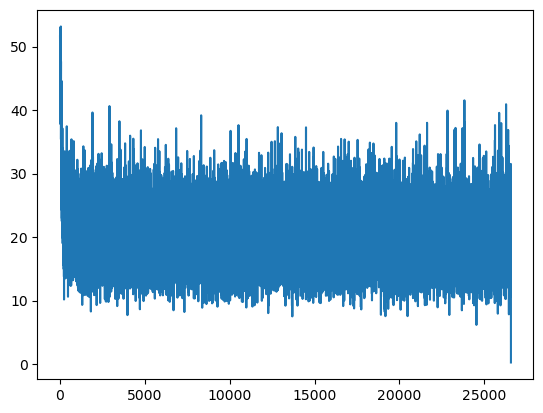

In [13]:
plt.plot(lst_train_loss)

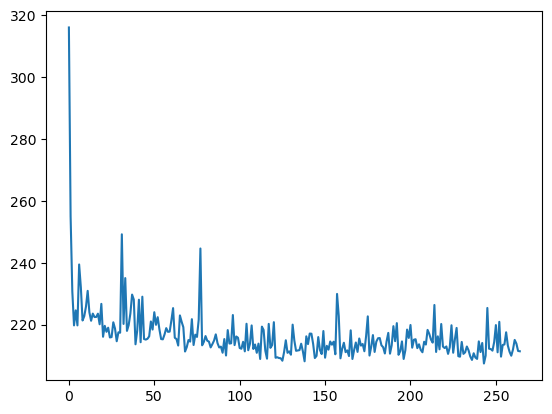

In [14]:
plt.plot(lst_eval_loss)

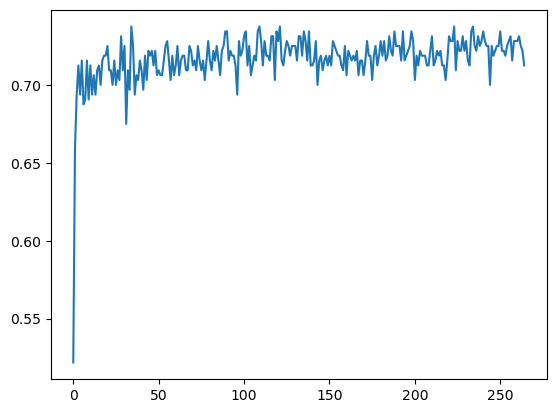

In [15]:
plt.plot(lst_hit_rates)

In [16]:
correct, total = 0, 0
lst_hit_rates = []
model.eval()
with torch.no_grad():
    for batch_x, batch_y in tqdm(val_loader, desc="Hit Rate Eval", unit="batch"):
        
        batch_y = torch.argmax(batch_y, dim=1) 
        
        batch_x = batch_x.to("cuda")
        batch_y = batch_y.to("cuda")
        
        pred = model(batch_x)

        # Compute hit rate
        y_pred_classes = torch.argmax(torch.softmax(pred, dim=1), dim=1)
        # y_true_classes = torch.argmax(batch_y, dim=1) # TK TK ADD BACK FOR EMD

        correct += (y_pred_classes == batch_y).sum().item()
        total += len(batch_x)
        
    hit_rate = correct / total
    lst_hit_rates.append(hit_rate)

Hit Rate Eval:   0%|          | 0/32 [00:00<?, ?batch/s]

In [17]:
print(lst_hit_rates[0])

0.7259332023575639
